In [1]:
import pandas as pd
import numpy as np
import os
import torch

from Model.Query2Label_pl import Query2Label_pl


model_dir = "/mnt/d/ML/Kaggle/CAFA6-new/downloads/test/"

In [2]:
# Load configs
import json
with open(os.path.join(model_dir, "configs.json"), "r") as f:
    configs = json.load(f)

model_configs = configs["model_configs"]
print("Model configs:", model_configs)

Model configs: {'token_dim': 512, 'num_tokens': 64, 'max_terms': 64, 'nheads': 8, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'dim_feedforward': 2048, 'dropout': 0.3, 'use_positional_encoding': False}


In [3]:
# Load model from checkpoint
checkpoint_path = os.path.join(model_dir, "epoch=07-val_f1_macro_go=0.1284.ckpt")

# Load the model using Lightning's load_from_checkpoint
model = Query2Label_pl.load_from_checkpoint(
    checkpoint_path,
    strict=False  # In case there are minor mismatches
)

# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model loaded successfully!
Model has 15797312 parameters


/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.6


In [4]:
# Build and load tokenizer
from Utils.tokenizer import EmbedTokenizer

# Get embedding dimension from configs
token_d = int(model_configs.get('token_dim', 512))
num_tokens = int(model_configs.get('num_tokens', 64))

# We'll determine embedding_dim from data later, for now create tokenizer
# The tokenizer will be properly initialized when we load its state
tokenizer = EmbedTokenizer(D=1280, d=token_d, N=num_tokens)  # ESM-650M dim is 1280

# Load tokenizer state
tokenizer_path = os.path.join(model_dir, "tokenizer_state_dict.pt")
tokenizer_state = torch.load(tokenizer_path, map_location='cpu')
tokenizer.load_state_dict(tokenizer_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = tokenizer.to(device)
tokenizer.eval()

print(f"Tokenizer loaded successfully on {device}!")
# print(f"Tokenizer: D={tokenizer.D}, d={tokenizer.d}, N={tokenizer.N}")

Tokenizer loaded successfully on cuda!


In [5]:
# Define data paths
data_paths = {
    "knn_terms_df":         "/mnt/d/ML/Kaggle/CAFA6-new/uniprot/diamond_knn_predictions.parquet",
    "train_terms_df":       "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv",
    "go_obo_path":          "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/go-basic.obo",
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_embeds.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_ids.npy",
    "go_embeds_paths":      "/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl"
}

print("Data paths configured")

Data paths configured


In [6]:
# Prepare data using the prepare_data function
from Dataset.Utils import prepare_data

max_terms = model_configs.get('max_terms', 64)
aspect = configs['training_configs'].get('aspect', 'P')

print(f"Preparing data with max_terms={max_terms}, aspect={aspect}...")
data = prepare_data(data_paths, max_terms=max_terms, aspect=aspect)
print(f"Data preparation complete!")
print(f"Number of sequences: {len(data['seq_2_terms'])}")
print(f"Number of GO embeddings: {len(data['go_embeds'])}")

Preparing data with max_terms=64, aspect=P...
Padding terms_predicted with GO graph neighbors...
Padding complete. Average terms per row: 63.42
Data preparation complete!
Number of sequences: 53315
Number of GO embeddings: 40122


In [7]:
# Check if all true predictions from train_terms_all are present in terms_predicted
def check_coverage(row):
    """Check what percentage of train_terms_all are in terms_predicted"""
    # Check if train_terms_all is None or empty list
    if row['terms_true'] is None or (isinstance(row['terms_true'], list) and len(row['terms_true']) == 0):
        return None
    
    train_set = set(row['terms_true'])
    pred_set = set(row['terms_predicted'])
    
    # Find terms in train_terms_all that are in terms_predicted
    covered_terms = train_set.intersection(pred_set)
    
    # Calculate coverage percentage
    coverage = len(covered_terms) / len(train_set) * 100 if len(train_set) > 0 else 0
    
    return {
        'total_train_terms': len(train_set),
        'covered_terms': len(covered_terms),
        'missing_terms': len(train_set) - len(covered_terms),
        'coverage_pct': coverage,
        'missing_term_list': list(train_set - covered_terms)
    }

# Apply the check
coverage_results = data['seq_2_terms'].apply(check_coverage, axis=1)
coverage_df = pd.DataFrame(coverage_results.tolist())

# Combine with original data
analysis_df = pd.concat([data['seq_2_terms'], coverage_df], axis=1)
print("=== Coverage Analysis ===")
print(f"\nOverall Statistics:")
print(f"Average coverage: {coverage_df['coverage_pct'].mean():.2f}%")
print(f"Median coverage: {coverage_df['coverage_pct'].median():.2f}%")
print(f"Min coverage: {coverage_df['coverage_pct'].min():.2f}%")
print(f"Max coverage: {coverage_df['coverage_pct'].max():.2f}%")
print(f"\nRows with 100% coverage: {(coverage_df['coverage_pct'] == 100).sum()} / {len(coverage_df)}")
print(f"Rows with 0% coverage: {(coverage_df['coverage_pct'] == 0).sum()} / {len(coverage_df)}")
print(f"\nAverage missing terms per row: {coverage_df['missing_terms'].mean():.2f}")
print(f"Total train terms checked: {coverage_df['total_train_terms'].sum()}")
print(f"Total covered terms: {coverage_df['covered_terms'].sum()}")
print(f"Total missing terms: {coverage_df['missing_terms'].sum()}")

=== Coverage Analysis ===

Overall Statistics:
Average coverage: 80.67%
Median coverage: 100.00%
Min coverage: 0.00%
Max coverage: 100.00%

Rows with 100% coverage: 36819 / 53315
Rows with 0% coverage: 3976 / 53315

Average missing terms per row: 1.33
Total train terms checked: 235392
Total covered terms: 164739
Total missing terms: 70653


In [8]:
# Create dataset and dataloader
from Dataset.EmbeddingsDataset import EmbeddingsDataset, collate_tokenize, PrefetchLoader
from torch.utils.data import DataLoader

# Use all data for inference
all_indices = list(range(len(data['seq_2_terms'])))
test_dataset = EmbeddingsDataset(data, oversample_indices=all_indices)

batch_size = configs['training_configs'].get('batch_size', 64)
num_workers = configs['training_configs'].get('num_workers', 0)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=lambda b: collate_tokenize(b)
)

# Wrap with PrefetchLoader for GPU tokenization
test_loader = PrefetchLoader(test_loader, device, tokenizer=tokenizer)

print(f"Dataset created with {len(test_dataset)} samples")
print(f"Batch size: {batch_size}")

Dataset created with 53315 samples
Batch size: 64


In [15]:
# Run inference and generate predictions
from tqdm.notebook import tqdm

model = model.to(device)
model.eval()

# Store predictions and labels as arrays (not dicts)
predictions_list = []
true_list = []
print(f"Running inference on {len(test_dataset)} samples...")

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i % 50 == 0:
            print(f"Processing batch {i} / {len(test_loader)}")
        
        x = batch['go_embed']
        f = batch['feature']
        true_labels = batch['label']
        
        # Forward pass
        logits = model(x, f)
        probs = torch.sigmoid(logits)
        
        # Move to CPU and store as numpy arrays
        probs_cpu = probs.cpu().numpy()
        labels_cpu = true_labels.cpu().numpy()
        
        # Append arrays (not dicts!)
        predictions_list.append(probs_cpu)
        true_list.append(labels_cpu)
        
        # Free memory
        del logits, probs, probs_cpu, labels_cpu, x, f

print(f"\nInference complete! Processed {len(predictions_list)} batches")

Running inference on 53315 samples...
Processing batch 0 / 834
Processing batch 50 / 834
Processing batch 100 / 834
Processing batch 150 / 834
Processing batch 200 / 834
Processing batch 250 / 834
Processing batch 300 / 834
Processing batch 350 / 834
Processing batch 400 / 834
Processing batch 450 / 834
Processing batch 500 / 834
Processing batch 550 / 834
Processing batch 600 / 834
Processing batch 650 / 834
Processing batch 700 / 834
Processing batch 750 / 834
Processing batch 800 / 834

Inference complete! Processed 834 batches


In [17]:
predictions_list = np.vstack(predictions_list)
true_list = np.vstack(true_list)

print(f"Predictions array shape: {predictions_list.shape}")
print(f"True labels array shape: {true_list.shape}")

Predictions array shape: (53315, 64)
True labels array shape: (53315, 64)


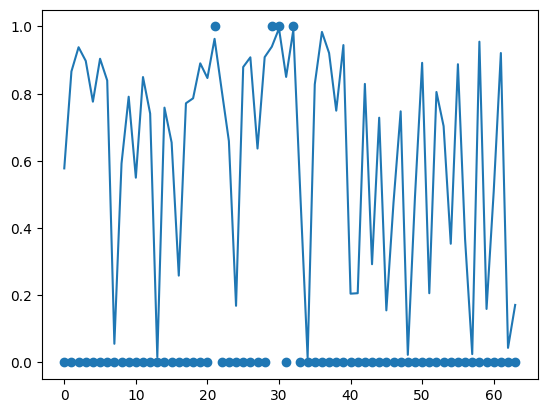

In [18]:
import matplotlib.pyplot as plt 
i = 104
plt.plot(np.arange(predictions_list[i].shape[0]), predictions_list[i])
plt.scatter(np.arange(true_list[i].shape[0]), true_list[i])

In [19]:
# Rebuild predictions and ground truth DataFrames from arrays
# We need to match predictions back to EntryIDs and terms

entry_ids_list = []
terms_list = []

for idx in all_indices:
    row = data['seq_2_terms'].iloc[idx]
    entry_ids_list.append(row['qseqid'])
    terms_list.append(row['terms_predicted'])

print(f"Collected {len(entry_ids_list)} entries with their terms")
print(f"Predictions shape: {predictions_list.shape}")
print(f"True labels shape: {true_list.shape}")

Collected 53315 entries with their terms
Predictions shape: (53315, 64)
True labels shape: (53315, 64)


In [20]:
# Function to create predictions DataFrame with top-k filtering
def create_topk_predictions_df(predictions_array, true_array, entry_ids, terms_lists, top_k=None):
    """
    Create predictions and ground truth DataFrames from arrays.
    
    Args:
        predictions_array: (N, M) array of prediction scores
        true_array: (N, M) array of true labels (0 or 1)
        entry_ids: List of N entry IDs
        terms_lists: List of N term lists (each with M terms)
        top_k: If provided, only keep top-k predictions per sample
    
    Returns:
        predictions_df: DataFrame with ['EntryID', 'term', 'score']
        ground_truth_df: DataFrame with ['EntryID', 'term']
    """
    pred_records = []
    gt_records = []
    
    for i in range(len(entry_ids)):
        entry_id = entry_ids[i]
        terms = terms_lists[i]
        scores = predictions_array[i]
        labels = true_array[i]
        
        # Sort by score descending and get top-k if specified
        if top_k is not None:
            sorted_indices = np.argsort(scores)[::-1][:top_k]
        else:
            sorted_indices = np.arange(len(scores))
        
        # Add predictions (only top-k if specified)
        for idx in sorted_indices:
            pred_records.append({
                'EntryID': entry_id,
                'term': terms[idx],
                'score': float(scores[idx])
            })
        
        # Add ground truth (all true labels)
        for idx in range(len(terms)):
            if labels[idx] > 0.5:  # True label
                gt_records.append({
                    'EntryID': entry_id,
                    'term': terms[idx]
                })
    
    predictions_df = pd.DataFrame(pred_records)
    ground_truth_df = pd.DataFrame(gt_records)
    
    return predictions_df, ground_truth_df

# Test with no filtering first
pred_df_full, gt_df = create_topk_predictions_df(
    predictions_list, true_list, entry_ids_list, terms_list, top_k=None
)

print(f"Full predictions: {len(pred_df_full)} records")
print(f"Ground truth: {len(gt_df)} records")
print(f"Unique proteins in predictions: {pred_df_full['EntryID'].nunique()}")
print(f"Unique proteins in ground truth: {gt_df['EntryID'].nunique()}")

Full predictions: 3412160 records
Ground truth: 164739 records
Unique proteins in predictions: 53315
Unique proteins in ground truth: 49339


In [21]:
# Compute F-max function (adapted from test.py)
def compute_fmax_topk(predictions_df, ground_truth_df):
    """
    Compute F-max, precision, and recall for predictions.
    For top-k predictions, we don't use threshold sweeping - just compute metrics directly.
    
    Args:
        predictions_df: DataFrame with columns ['EntryID', 'term', 'score']
        ground_truth_df: DataFrame with columns ['EntryID', 'term']
    
    Returns:
        dict with f1, precision, recall
    """
    print("Building ground truth dictionary...")
    # Build ground truth set per EntryID
    gt_dict = {}
    for entry_id, group in ground_truth_df.groupby('EntryID'):
        gt_dict[entry_id] = set(group['term'].values)
    
    # Build prediction dict
    pred_dict = {}
    for entry_id, group in predictions_df.groupby('EntryID'):
        pred_dict[entry_id] = set(group['term'].values)
    
    # Get all entry IDs
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    # Calculate TP, FP, FN
    tp = 0
    fp = 0
    fn = 0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        tp += len(true_terms & pred_terms)
        fp += len(pred_terms - true_terms)
        fn += len(true_terms - pred_terms)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

# Test with full predictions
print("=== Metrics with ALL predictions ===")
metrics_full = compute_fmax_topk(pred_df_full, gt_df)

=== Metrics with ALL predictions ===
Building ground truth dictionary...
TP: 164739, FP: 3247421, FN: 0
Precision: 0.0483
Recall: 1.0000
F1: 0.0921


In [22]:
# Now test with different top-k values
top_k_values = [4, 8, 16, 32]

results = []

for k in top_k_values:
    print(f"\n{'='*60}")
    print(f"=== Metrics with TOP-{k} predictions per sample ===")
    print(f"{'='*60}")
    
    # Create top-k predictions
    pred_df_topk, _ = create_topk_predictions_df(
        predictions_list, true_list, entry_ids_list, terms_list, top_k=k
    )
    
    print(f"Total predictions (top-{k}): {len(pred_df_topk)}")
    print(f"Avg predictions per protein: {len(pred_df_topk) / pred_df_topk['EntryID'].nunique():.2f}")
    
    # Compute metrics
    metrics = compute_fmax_topk(pred_df_topk, gt_df)
    metrics['top_k'] = k
    results.append(metrics)
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY: F1 Scores by Top-K")
print("="*60)
print(results_df[['top_k', 'precision', 'recall', 'f1']])


=== Metrics with TOP-4 predictions per sample ===
Total predictions (top-4): 213260
Avg predictions per protein: 4.00
Building ground truth dictionary...
TP: 37486, FP: 175774, FN: 127253
Precision: 0.1758
Recall: 0.2275
F1: 0.1983


=== Metrics with TOP-8 predictions per sample ===
Total predictions (top-8): 426520
Avg predictions per protein: 8.00
Building ground truth dictionary...
TP: 62173, FP: 364347, FN: 102566
Precision: 0.1458
Recall: 0.3774
F1: 0.2103


=== Metrics with TOP-16 predictions per sample ===
Total predictions (top-16): 853040
Avg predictions per protein: 16.00
Building ground truth dictionary...
TP: 91056, FP: 761984, FN: 73683
Precision: 0.1067
Recall: 0.5527
F1: 0.1789


=== Metrics with TOP-32 predictions per sample ===
Total predictions (top-32): 1706080
Avg predictions per protein: 32.00
Building ground truth dictionary...
TP: 123436, FP: 1582644, FN: 41303
Precision: 0.0724
Recall: 0.7493
F1: 0.1320


SUMMARY: F1 Scores by Top-K
   top_k  precision    recal

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Precision
axes[0].plot(results_df['top_k'], results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Top-K', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision vs Top-K', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log', base=2)

# Plot Recall
axes[1].plot(results_df['top_k'], results_df['recall'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Top-K', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall vs Top-K', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log', base=2)

# Plot F1
axes[2].plot(results_df['top_k'], results_df['f1'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Top-K', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score vs Top-K', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log', base=2)

# Mark best F1
best_idx = results_df['f1'].idxmax()
best_k = results_df.loc[best_idx, 'top_k']
best_f1 = results_df.loc[best_idx, 'f1']
axes[2].scatter([best_k], [best_f1], color='red', s=200, zorder=5, marker='*')
axes[2].annotate(f'Best: k={best_k}\nF1={best_f1:.4f}', 
                 xy=(best_k, best_f1), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nBest F1 Score: {best_f1:.4f} at Top-K = {best_k}")